# Fractopo – Fracture Network Analysis

In [1]:
import geopandas as gpd

/home/nialov/nikke-projects/Pipenv_projects/projvenv/projvenv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


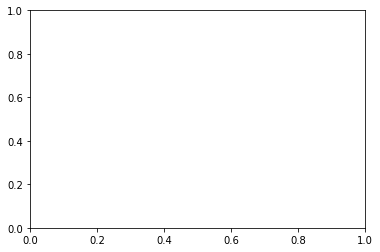

In [2]:
from fractopo.analysis.network import Network

## Data

In [3]:
# Trace and target area data available on GitHub
trace_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11_traces.geojson"
area_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11_area.geojson"

# Use geopandas to load data from urls
traces = gpd.read_file(trace_data_url)
area = gpd.read_file(area_data_url)

# Name the dataset
name = "KB11"

In [4]:
# Create Network and automatically determine branches and nodes
kb11_network = Network(traces, area,name=name, determine_branches_nodes=True)

Loop :1


27029-ERROR-Did not find 2 EXYI-nodes that intersected branch endpoints.



## Rose plots

27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


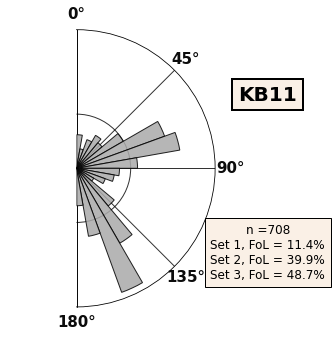

In [5]:
# Plot azimuth rose plot of fracture traces
azimuth_bin_dict, fig, ax = kb11_network.plot_trace_azimuth()

## Length distributions

Calculating best minimal value for power law fit
/home/nialov/nikke-projects/Pipenv_projects/projvenv/projvenv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/nialov/nikke-projects/Pipenv_projects/projvenv/projvenv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/nialov/nikke-projects/Pipenv_projects/projvenv/projvenv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


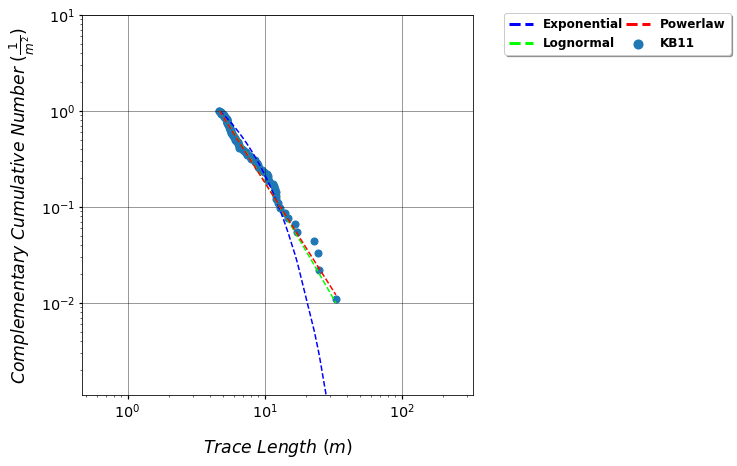

In [6]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture traces
fit, fig, ax = kb11_network.plot_trace_lengths()

In [7]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit.xmin}")
print(f"Powerlaw exponent: {fit.alpha - 1}")
print(f"Compare powerlaw fit to lognormal: R, p = {fit.distribution_compare('power_law', 'lognormal')}")

Automatically determined powerlaw cut-off: 4.677907783545403
Powerlaw exponent: 2.257368239803986
Compare powerlaw fit to lognormal: R, p = (-0.04925240638059558, 0.823392969372061)


## Crosscutting and abutting relationships

In [8]:
# Sets are defaults
print(f"Azimuth set names: {kb11_network.azimuth_set_names}")
print(f"Azimuth set ranges: {kb11_network.azimuth_set_ranges}")

Azimuth set names: ('1', '2', '3')
Azimuth set ranges: ((0, 60), (60, 120), (120, 180))


27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


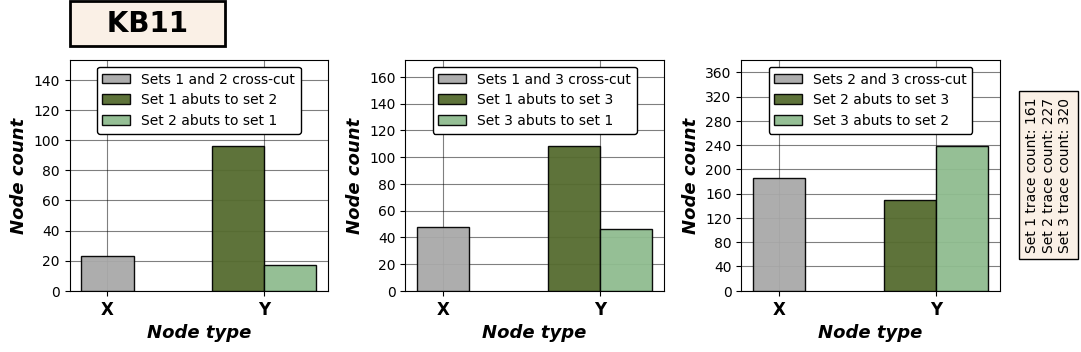

In [9]:
# Plot crosscutting and abutting relationships between azimuth sets
figs, fig_axes = kb11_network.plot_azimuth_crosscut_abutting_relationships()

## Node and branch proportions

In [11]:
kb11_network.node_counts

{'X': 272, 'Y': 828, 'I': 476, 'E': 114}

(<Figure size 468x367.2 with 1 Axes>,
 <AxesSubplot:>,
 TernaryAxesSubplot: 8777296696929)

27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
27029-WARNING-findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


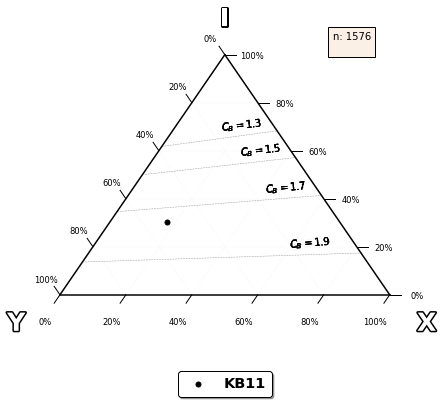

In [12]:
# Plot ternary XYI-node proportion plot
kb11_network.plot_xyi()

In [13]:
kb11_network.branch_counts

{'C - C': 1532, 'C - I': 408, 'I - I': 28}

(<Figure size 468x367.2 with 1 Axes>,
 <AxesSubplot:>,
 TernaryAxesSubplot: 8777296720912)

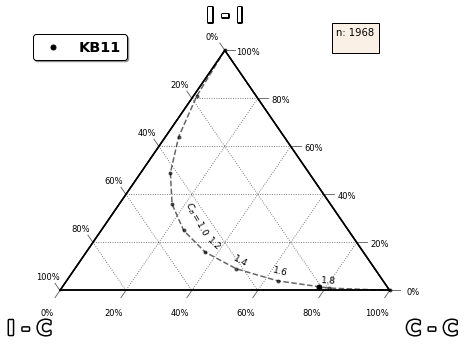

In [14]:
# Plot ternary branch (C-C, C-I, I-I) proportion plot
kb11_network.plot_branch()